forked from iowa_contiguousdistricting on october 30

testing a contiguity measure which doesn't include kitty-corners

Shapefile dataframes used in this notebook

shapefile_iowa: MGGG stuff merged with census stuff

shapef_ia_proj: projected to UTM so we can run distance calculations on it

shapef_ia_fordistricting: 99 rows for each county, ready for initial allocation; made from deep copy of shapef_ia_proj

In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
import glob
import os       #mkdir
from scipy.sparse import csgraph #for laplacian
from scipy.linalg import null_space
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 

import math         ##for math.sqrt
import random       #for random selection of district to start with

# OLD/unchanged stuff in the runup:

Prepping the census and geopandas dataframes (all same as _contiguousdistricting file)

(except some small modifications to map function)

## Importing data

In [2]:
#census.csv is data from Secretary of State's office.
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')
census_df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [3]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)
shapefile_iowa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   99 non-null     object  
 1   COUNTYFP10  99 non-null     object  
 2   GEOID10     99 non-null     int64   
 3   NAME10      99 non-null     object  
 4   NAMELSAD10  99 non-null     object  
 5   ALAND10     99 non-null     int64   
 6   AWATER10    99 non-null     int64   
 7   INTPTLAT10  99 non-null     object  
 8   INTPTLON10  99 non-null     object  
 9   TOTPOP      99 non-null     int64   
 10  NH_WHITE    99 non-null     int64   
 11  NH_BLACK    99 non-null     int64   
 12  NH_AMIN     99 non-null     int64   
 13  NH_ASIAN    99 non-null     int64   
 14  NH_NHPI     99 non-null     int64   
 15  NH_OTHER    99 non-null     int64   
 16  NH_2MORE    99 non-null     int64   
 17  HISP        99 non-null     int64   
 18  H_WHITE     99 non-null     int64   
 19  H_

In [4]:
## Merging ONLY 2020 population numbers and county_id from census df into shapefile_iowa
shapefile_iowa = shapefile_iowa.merge(census_df[['COUNTYFP10','population','county_id']], on='COUNTYFP10').copy()

In [5]:
county_populations = np.array(census_df['population'])
state_population = sum(county_populations)
n_counties = 99
n_districts = 4

## Projecting shapefile to UTM 15N

In [6]:
#First, show the current coordinate reference system
shapefile_iowa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
#Then project the shapefiles to UTM 15N
shapef_ia_proj = shapefile_iowa.to_crs(epsg=26915)

shapef_ia_proj.crs

<Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 96°W to 90°W and NAD83 by country
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
#checking out geopandas automatic distance calculation
shapef_ia_proj['geometry'].iloc[0].distance(shapef_ia_proj['geometry'].iloc[1])
# adair-to-adams distance is 0, so shortest distance, not centroid-to-centroid

0.0

## Merging pd and gpd dataframes and creating population heat map

In [9]:
## Merging ONLY lat/long + county id from census df into shapefile_iowa (since population and county_id are already there)
map_population_by_county_data = shapefile_iowa.merge(census_df[['COUNTYFP10','latitude','longitude']], on='COUNTYFP10').copy()

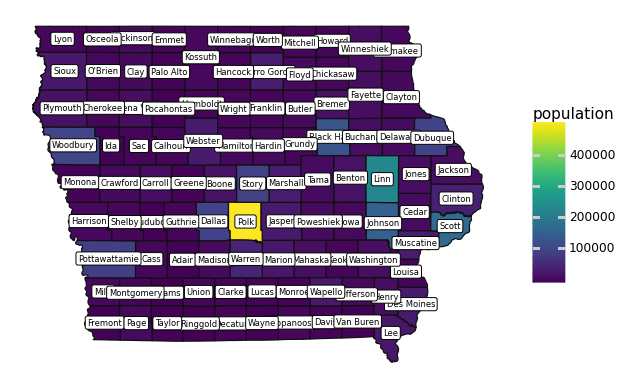

<ggplot: (8775958412855)>

In [10]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

In [11]:
#input: shapefile of counties within a particular district 
#   (after undergoing identity overlay)
#   label_field options: 'NAME10', 'population_2', 'county_id', 'county_id_string_2', etc
def map_unmerged_districts(new_shapefile,label_field):
    map_counties_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population'))
        + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                        label=label_field,size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_counties_by_district

## Creating distance matrix for Iowa counties

In [12]:
# adding/fixing columns with (projected) centroid locations 
shapef_ia_proj['xcentr_lon'] = shapef_ia_proj.centroid.x
shapef_ia_proj['ycentr_lat'] = shapef_ia_proj.centroid.y
#shapef_ia_proj.info()
# shapef_ia_proj['xcentr_lon'].iloc[1]

In [13]:
# cutting out other columns from the shapefile to be dissolved on

# 'TOTPOP' is the MGGG shapefile totpop (pre-2020), so removing
# also removing: the un-projected 'INTPTLAT10' and 'INTPTLON10'
#      and 'NAMELSAD10', the 2 word name
#      and all demographic/voting data
#      and (later on): also removing ALAND and AWATER, since they just get messy with merges and dissolves

districting_columns = ['COUNTYFP10', 'NAME10', 'geometry', 
       'population', 'county_id', 'xcentr_lon', 'ycentr_lat']

#make a new shapefile, which will be merged/dissolved on in the process of making districts
shapef_ia_fordistricting = shapef_ia_proj[districting_columns].copy()

#add column of county indices (which will get concatenated, as county_id_string)
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id']
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id_string'].astype(str).str.pad(2,fillchar='0')

#add column of county indices (which will become district indices)
shapef_ia_fordistricting['temp_district'] = shapef_ia_fordistricting.index

shapef_ia_fordistricting.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   COUNTYFP10        99 non-null     object  
 1   NAME10            99 non-null     object  
 2   geometry          99 non-null     geometry
 3   population        99 non-null     int64   
 4   county_id         99 non-null     int64   
 5   xcentr_lon        99 non-null     float64 
 6   ycentr_lat        99 non-null     float64 
 7   county_id_string  99 non-null     object  
 8   temp_district     99 non-null     int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 7.7+ KB


# NEW! Set up subset of counties to test for adjacency, kitty-corners

In [14]:
shapef_ia_fordistricting[["NAME10","county_id"]]

,NAME10,county_id
0,Adair,0
1,Adams,1
2,Allamakee,2
3,Appanoose,3
4,Audubon,4
...,...,...
94,Winnebago,94
95,Winneshiek,95
96,Woodbury,96
97,Worth,97


Pick the southwest corner of the state to work with, including some kitty-corners and some small overlaps


[Monona, Crawford, Carroll]
Harrison, Shelby, Audubon, Guthrie
Pottawattamie, Cass, Adair
Mills, Montgom, Adams
Fremont, Page, Taylor


[66, 23, 13]
42, 82, 04, 38
77, 14, 00
64,68,01
35,72,86

In [15]:
test_counties_ids= [42,82,4,38,77,14,0,64,68,1,35,72,86]
test_counties_ids.sort()
test_counties_ids

[0, 1, 4, 14, 35, 38, 42, 64, 68, 72, 77, 82, 86]

In [16]:
shapef_testcounties = shapef_ia_fordistricting.iloc[test_counties_ids].copy()

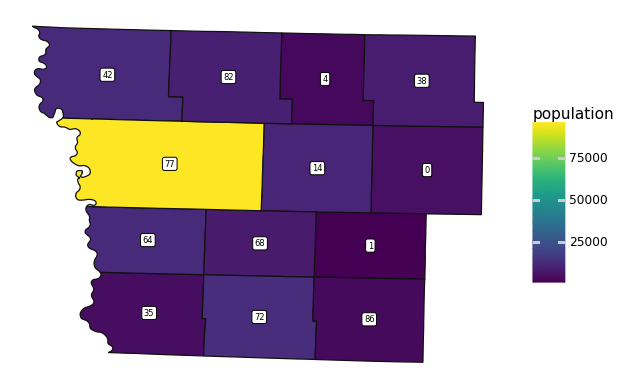

<ggplot: (8775956285380)>

In [17]:
# map_unmerged_districts(shapef_testcounties,'NAME10')
map_unmerged_districts(shapef_testcounties,'county_id')

# ORIGINAL ADJ_MAT_CALC which is used everywhere adjacency is calculated:

In [18]:
# function for arbitrary adjacency matrix

def adj_mat_calc(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    adjac_mat = pd.DataFrame()

    for i in range(curr_n_districts):
        adjac_mat[i] = temp_shapefile.intersects(temp_shapefile.iloc[[i]].unary_union)
    
    adjac_mat = adjac_mat - np.identity(curr_n_districts)
    adjac_mat = adjac_mat.astype(int)

    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)

    return adjac_mat


In [34]:
#calculating the old way, where kitty-corner counts as adjacent
adj_mat_calc(shapef_testcounties)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,1,1,1,0,1,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,1,1,0,0,1
4,1,0,0,1,0,1,0,0,0,0,0,1,0
14,1,1,1,0,0,1,0,0,1,0,1,1,0
35,0,0,0,0,0,0,0,1,1,1,0,0,0
38,1,0,1,1,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,1,1,0
64,0,0,0,0,1,0,0,0,1,1,1,0,0
68,0,1,0,1,1,0,0,1,0,1,1,0,1
72,0,1,0,0,1,0,0,1,1,0,0,0,1


# NEW adj_mat_calc options!

In [35]:
shapef_testcounties.intersects(shapef_testcounties.iloc[[0]].unary_union)

0      True
1      True
4      True
14     True
35    False
38     True
42    False
64    False
68    False
72    False
77    False
82    False
86    False
dtype: bool

In [21]:
# geopandas tool "intersects" (used above) gives boolean yes/no
# geopandas tool "intersection" gives the actual intersection.
# here, we test with Adair county (county 00):
# the intersection with itself is a polygon
# the intersections with 1, 14, and 38 are lines ("multilinestring") in geopandas-speak
# the intersection with 4 is a point
# all other intersections are empty

shapef_testcounties.intersection(shapef_testcounties.iloc[[0]].unary_union)

# putting .geom_type at the end grabs the specific geometry type:
# shapef_testcounties.intersection(shapef_testcounties.iloc[[0]].unary_union).geom_type

0     POLYGON ((386139.673 4557123.147, 385899.972 4...
1     MULTILINESTRING ((357317.284 4557700.050, 3578...
4                        POINT (358067.272 4596120.802)
14    MULTILINESTRING ((358067.272 4596120.802, 3580...
35                                        POLYGON EMPTY
38    MULTILINESTRING ((396378.070 4595416.727, 3963...
42                                        POLYGON EMPTY
64                                        POLYGON EMPTY
68                                        POLYGON EMPTY
72                                        POLYGON EMPTY
77                                        POLYGON EMPTY
82                                        POLYGON EMPTY
86                                        POLYGON EMPTY
dtype: geometry

In [22]:
#could test length specifically, and cut off things which barely
#       intersect by adding a threshold?
#or! could use this as a proxy for cutting out the kittycorners!
#"length" of a Point is 0, just like the empty polygons
shapef_testcounties.intersection(shapef_testcounties.iloc[[0]].unary_union).length


0     153802.729052
1      19319.245387
4          0.000000
14     38441.242159
35         0.000000
38     38346.312659
42         0.000000
64         0.000000
68         0.000000
72         0.000000
77         0.000000
82         0.000000
86         0.000000
dtype: float64

## GOOD/FINAL actual working solution:

use .length and np.sign

In [32]:
# function for arbitrary adjacency matrix

def adj_mat_calc_new(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    adjac_mat = pd.DataFrame()
    # adjac_mat = np.zeros([curr_n_districts,curr_n_districts])

    for i in range(curr_n_districts):
        adjac_mat[i] = temp_shapefile.intersection(temp_shapefile.iloc[[i]].unary_union).length
    
    #sign function turns all nonzero entries to 1
    adjac_mat = np.sign(adjac_mat)

    #eliminate diagonals, so county i is not adjacent to itself
    adjac_mat = adjac_mat - np.identity(curr_n_districts)

    # make everything an integer
    adjac_mat = adjac_mat.astype(int)

    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)

    return adjac_mat


In [33]:
adj_mat_calc_new(shapef_testcounties)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,1,0,1,0,1,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,1,0,0,0,1
4,0,0,0,1,0,1,0,0,0,0,0,1,0
14,1,1,1,0,0,0,0,0,1,0,1,1,0
35,0,0,0,0,0,0,0,1,0,1,0,0,0
38,1,0,1,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,1,1,0
64,0,0,0,0,1,0,0,0,1,0,1,0,0
68,0,1,0,1,0,0,0,1,0,1,1,0,0
72,0,0,0,0,1,0,0,0,1,0,0,0,1


## bad/temp/old idea: work with intersection raw or with geom_type by category

if statement: if intersection is multiline, enter a 1 in the array, etc

but it wasn't working, and also might be less good overall than working with lengths

In [23]:
# we can pairwise check this: now, adair vs adams
shapef_testcounties.iloc[[1]].intersection(shapef_testcounties.iloc[[0]].unary_union)

1    MULTILINESTRING ((357317.284 4557700.050, 3578...
dtype: geometry

In [24]:
# use actual index within set, not fake/old county number index
shapef_testcounties.iloc[[2]].intersection(shapef_testcounties.iloc[[0]].unary_union)

4    POINT (358067.272 4596120.802)
dtype: geometry

In [25]:
# geom_type gives the geometry type, but in a series, not by itself
shapef_testcounties.iloc[[1]].intersection(shapef_testcounties.iloc[[0]].unary_union).geom_type

1    MultiLineString
dtype: object

next goal to do an if statement off this geom_type, but that is tough because it is a (one element) series, not a stand-alone thing.

So! Back to just doing length!

In [74]:
# function for arbitrary adjacency matrix

def adj_mat_calc_bad(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    # adjac_mat = pd.DataFrame()
    adjac_mat = np.zeros([curr_n_districts,curr_n_districts])

    for i in range(curr_n_districts):
        for j in range(i):      #only go from j=0 to j=i-1, so skipping diagonals
            adjac_mat[i,j]=1    #test case for diagonals and such
            intersect_geom = temp_shapefile.iloc[[j]].intersection(temp_shapefile.iloc[[i]].unary_union)
            if (intersect_geom.geom_type == 'MultiLineString'):
                adjac_mat[i,j] = 1
                adjac_mat[j,i] = 1
    
    # adjac_mat = adjac_mat - np.identity(curr_n_districts)
    # adjac_mat = adjac_mat.astype(int)

    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)

    return adjac_mat


# other locations where adj_mat_calc is called

just here to confirm output/input is still ok

In [22]:
#-----------module to find neighboring districts with the greatest population difference---------------------
def neighbor_popdiff_fun(df):
    #adjacencey matrix for 4 districts
    adj_mat_array = adj_mat_calc(df).to_numpy()   

    #SIGNED population difference array
    # row minus col
    # positive value in row i column j means that pop(i) > pop(j)
    # negative value in row i column j means that pop(i) < pop(j)
    pop_diff_array = pop_diff_matrix(df)
    # zero out any pairs that aren't adjacent
    # for numpy arrays, "*" is piecewise multiplication
    neighbor_popdiff = adj_mat_array * pop_diff_array

    return neighbor_popdiff

In [25]:
#helper function to check for contiguity of big district as switch_func identifies a county
#to move from the big district to the small district

#note to self: moving_index=dataframe_sorted.iloc[i]['county_id']
def big_dist_contiguity_check_func(moving_index, big_dist_df):
    df=big_dist_df.loc[big_dist_df['county_id']!=moving_index]
    big_dist_laplacian=csgraph.laplacian(adj_mat_calc(df).to_numpy())
    return  null_space(big_dist_laplacian).shape[1]

def small_dist_contiguity_check_func(moving_index, border_counties, small_dist_df):
    moving_candidate=border_counties.loc[border_counties['county_id']==moving_index]
    df=small_dist_df.append(moving_candidate)
    small_dist_laplacian=csgraph.laplacian(adj_mat_calc(df).to_numpy())
    return null_space(small_dist_laplacian).shape[1]